In [1]:
#-- import modules -

import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import sys

from pycbc.psd.analytical import aLIGOAPlusDesignSensitivityT1800042, AdVDesignSensitivityP1200087, KAGRADesignSensitivityT1600593, KAGRA, AdvVirgo
from pycbc.psd.analytical import aLIGODesignSensitivityP1200087, aLIGOZeroDetHighPower
from pycbc.types.frequencyseries import load_frequencyseries
from pycbc.filter import sigma
from pycbc.psd.estimate import interpolate
from pycbc.types import FrequencySeries
from pycbc.noise.gaussian import frequency_noise_from_psd
from pycbc.detector import add_detector_on_earth
from pycbc.waveform import get_waveform_filter_length_in_time as duration
from pycbc.waveform import get_fd_waveform, get_td_waveform

### $\Rightarrow$ Adding a LIGO India Detector with the latest coordinates into PyCBC detector object

Reference: https://dcc.ligo.org/LIGO-T2000158/public

In [2]:
#-- adding LIGO India to PyCBC detectors --

add_detector_on_earth(name='A0', longitude=1.34444215058, latitude=0.34231676739,\
                      yangle=4.23039066080, xangle=5.80120119264, height=440)

## $\Rightarrow$Setting up the PSDs for IGWN detectors: 

Reference: https://dcc.ligo.org/LIGO-T2000012/public

* L1 : A+ Design target for O5 (https://dcc.ligo.org/public/0165/T2000012/002/AplusDesign.txt)
* H1 : A+ Design target for O5 (https://dcc.ligo.org/public/0165/T2000012/002/AplusDesign.txt)
* V1 : Virgo target sensitivity for O5 (low noise, high range limit) (https://dcc.ligo.org/public/0165/T2000012/002/avirgo_O5low_NEW.txt)

* K1 : KAGRA Sensitivity (80 Mpc) (used for O5 simulations) (https://dcc.ligo.org/public/0165/T2000012/002/kagra_80Mpc.txt)
* A0 : LIGO Sensitivity (160 Mpc) (Used for O4 Simulations) (https://dcc.ligo.org/public/0165/T2000012/002/aligo_O4low.txt)

In [3]:
#-- intrinsic source parameters -- 
    
m1_src = 1.387                     # MAP value of m1_src for GW170817 Bilby Analysis
m2_src = 1.326                     # MAP value of m2_src for GW170817 Bilby Analysis
s1z = 0.0001294116725339975        # MAP value of s1z for GW170817 Bilby Analysis
s2z = 3.5461352589076355e-05       # MAP value of s2z for GW170817 Bilby Analysis


In [4]:
#-- Checking what minimum waveform length in time (segLen) should be chosen for generating the signal --

fLow = 10       # Hz   (For O5 & beyond scenario)

signal_length = duration(approximant='IMRPhenomD', mass1=m1_src, mass2=m2_src, f_lower=fLow)

print('Waveform MODEL duration is %.2f seconds, if generated from 10 Hz'%signal_length)  # secs


Waveform MODEL duration is 1178.28 seconds, if generated from 10 Hz


In [14]:
#-- setting up the required params for PSD generation --

fLow, fHigh = 10, 1600    # Hz
segLen = 1500             # secs (duration of signal) (segLen > 1178.3 secs, and hence the template(1178.3 secs long) will be able to cover the DATA(1500 secs long) which is to be generated)
fSamp = 4096              # Hz   (Sampling Frequency)

delta_f = 1/segLen        # Hz

fLen = int(segLen*fSamp/2 + 1)      # No of Frequency Samples { No. of Frequency Samples  [ N_f = (N_t/2) + 1 ] }


###  $\Rightarrow$ Constructing PSDs with required $\Delta f$, using interpolation of the reference PSDs 

In [15]:
# -- loading the available ASDs available from the above reference --

base_path = os.getcwd() + '/reference_psds'

asd_o5 = np.loadtxt(base_path+'/PSD_AplusDesign_O5.txt')
asd_o4 = np.loadtxt(base_path+'/aligo_O4low.txt')
asd_o3 = np.loadtxt(base_path+'/aligo_L1_O3actual.txt')
asd_v1 = np.loadtxt(base_path+'/PSD_avirgo_O5low.txt')
asd_k1 = np.loadtxt(base_path+'/PSD_kagra_80Mpc.txt')

In [16]:
#-- to store the PSDs --

psd_dict = {}

#-- consider a reference PSD --

psd_ref = aLIGOZeroDetHighPower(length=fLen, delta_f=delta_f, low_freq_cutoff=fLow)

#-- replace zeros with e(-80) (non-zero values start from fLow)

psd_ref.data[np.where(psd_ref.data == 0)[0]] = 1e-80

In [17]:

asds = [asd_o5, asd_o4, asd_o3, asd_v1, asd_k1]

psd_name = ['O5', 'O4', 'O3', 'Virgo', 'KAGRA']


In [18]:
for i in range(len(asds)):
    
    #-- interpolated PSD --

    psd_interp = np.interp(x=psd_ref.sample_frequencies.data, xp=asds[i][:,0], fp=(asds[i][:, 1])**2)    

    #-- Turning to PyCBC Frequency Series --
    psd_dict[psd_name[i]] = FrequencySeries(psd_interp, delta_f=1/segLen)   

    #-- finding indices with sample frequencies < 10 Hz --
    idx = np.where(psd_ref.sample_frequencies.data < 10)[0]

    psd_dict[psd_name[i]].data[idx] = 1e-80

In [19]:
#-- Saving the 'USEFUL' PSDs -- (These are used for analysis in the paper)

for name in psd_name:
    
    psd_dict[name].save('PSD_%s_10Hz_to_2048Hz_nonzero.txt'%(name))

#### $\Rightarrow$ The PSDs have non-zero values for sample frequencies [10, 2048] Hz. For sample_frequencies less than 10 Hz i.e ```psd.sample_frequencies()``` $\in$ [0, 10) Hz, the PSD values are $10^{-80}$

In [20]:
#-- Choosing O4 PSD for LIGO India --
ifos = ['L1', 'H1', 'V1', 'K1', 'A0']

psds = {}

for ifo in ifos:
    
    if(ifo=='V1'):
        
        psds[ifo] = load_frequencyseries('PSD_Virgo_10Hz_to_2048Hz_nonzero.txt')
        
    elif(ifo=='K1'):
        
        psds[ifo] = load_frequencyseries('PSD_KAGRA_10Hz_to_2048Hz_nonzero.txt')
        
    elif(ifo=='A0'):
        
        psds[ifo] = load_frequencyseries('PSD_O4_10Hz_to_2048Hz_nonzero.txt')
        
    else:
        
        psds[ifo] = load_frequencyseries('PSD_O5_10Hz_to_2048Hz_nonzero.txt')

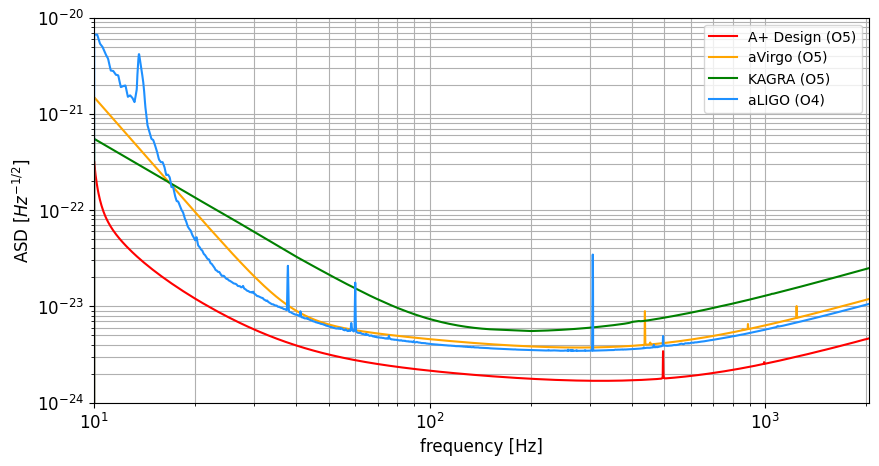

In [33]:
#-- PSD plot --

length, breadth = 10, 5

fig, ax = plt.subplots(1, 1, figsize=(length, breadth))

fontsize = 12

ax.loglog(psds['L1'].sample_frequencies, np.sqrt(psds['L1']), label='A+ Design (O5)', c='red')
ax.loglog(psds['V1'].sample_frequencies, np.sqrt(psds['V1']), label='aVirgo (O5)', c='orange')
ax.loglog(psds['K1'].sample_frequencies, np.sqrt(psds['K1']), label='KAGRA (O5)', c='green')
ax.loglog(psds['A0'].sample_frequencies, np.sqrt(psds['A0']), label='aLIGO (O4)', c='dodgerblue')
ax.set_xlabel(r'frequency [Hz]', fontsize=fontsize)
ax.set_ylabel(r'ASD [$Hz^{-1/2}$]', fontsize=fontsize)

ax.set_ylim(1e-24, 1e-20)
ax.set_xlim(9.9998, 2040)
#ax.axvline(x=10, c='k', alpha=0.5)

ax.grid(which='both')
#ax.minorticks_on()
ax.tick_params(labelsize=fontsize)
#ax.tick_params(axis='both', which='minor', length=2, width=0.5, direction='out')
#ax.tick_params(axis='both', which='major', length=4, width=0.4, direction='out')
ax.legend(fontsize=fontsize-2)
#fig.savefig("ASDs_LIGO_Aundha.png", dpi=200, bbox_inches='tight')
fig.show()

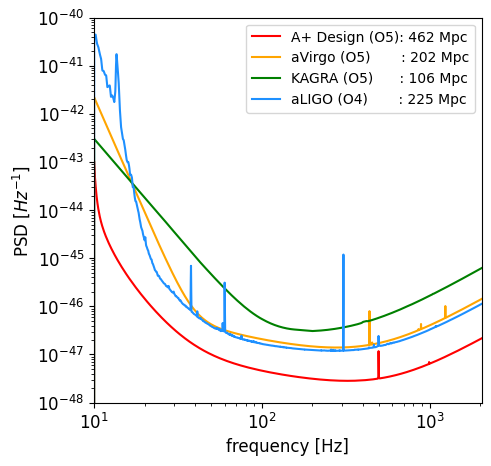

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

fontsize = 12

ax.loglog(psds['L1'].sample_frequencies, psds['L1'], label='A+ Design (O5): 462 Mpc', c='red')
ax.loglog(psds['V1'].sample_frequencies, psds['V1'], label='aVirgo (O5)       : 202 Mpc', c='orange')
ax.loglog(psds['K1'].sample_frequencies, psds['K1'], label='KAGRA (O5)      : 106 Mpc', c='green')
ax.loglog(psds['A0'].sample_frequencies, psds['A0'], label='aLIGO (O4)       : 225 Mpc', c='dodgerblue')
 
ax.set_xlabel(r'frequency [Hz]', fontsize=fontsize)
ax.set_ylabel(r'PSD [$Hz^{-1}$]', fontsize=fontsize)
ax.set_ylim(1e-48, 1e-40)
ax.set_xlim(9.9998, 2040)
#ax.axvline(x=10, c='k', alpha=0.5)
#ax.grid(which='both')
#ax.minorticks_on()
ax.tick_params(labelsize=fontsize)
#ax.tick_params(axis='both', which='minor', length=2, width=0.5, direction='out')
#ax.tick_params(axis='both', which='major', length=4, width=0.4, direction='out')
ax.legend(fontsize=10)
#fig.savefig("PSD_LIGO_Aundha_with_detection_range_1.4_Msolar.png", dpi=200, bbox_inches='tight')
fig.show()

### The numbers mentioned above are the sensemon ranges for a 1.4  -  1.4 $M_\odot$ BNS systems corresponding to a signal-to-noise ratio (SNR) of 6